Limitazione importante: hai bisogno di sufficienti pazienti per gruppo (minimo ~3, meglio 5–6+ per gruppo) per stimare varianza e avere potenza; con 1–2 pazienti per gruppo i risultati non sono affidabili

## Import

In [1]:
import os
#import json
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import decoupler as dc
import scanpy as sc
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

/home/rossi/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
input_path = "../phenotype_classification/output_phenotypes"

In [3]:
path = 'output'
output_path = os.path.join(path, 'infl_vs_excl')

## Load

In [4]:
adata = sc.read_h5ad(os.path.join(input_path, 'sc_phenotypes_unif_annotation.h5ad'))

In [5]:
phenotype_key = 'phenotype'
cell_type_key = 'celltype'
patient_key = 'patient_short'
tissue_region_key = 'tumor_source'

In [6]:
# exclude normal from analysis
adata_region = adata[adata.obs[tissue_region_key].isin(['core', 'border'])].copy()

In [7]:
# exclude phenotype ignored from analysis
adata = adata_region[adata_region.obs[phenotype_key].isin(['inflamed', 'excluded'])].copy()

In [8]:
# raw counts for deseq2
adata.X = adata.layers['counts'].copy()

In [9]:
adata.obs[cell_type_key].value_counts()

celltype
Neutrophil          8913
Cancer cell         8787
T cell              6063
Macrophage          1399
B cell               940
Plasma cell          726
Endothelial cell     447
Fibroblast           327
Dendritic cell       187
Mast cell            128
Epithelial cell       98
Schwann cell          15
Name: count, dtype: int64

## All cells

### Counts dataframe

In [10]:
adata.obs['patient_phenotype'] = (adata.obs[patient_key].astype(str) + " - " + adata.obs[phenotype_key].astype(str))
adata.obs['patient_phenotype'] = adata.obs['patient_phenotype'].astype('category')

counts_cancer = pd.DataFrame(adata.X.todense() if hasattr(adata.X, "todense") else adata_cancer.X, 
                             columns=adata.var['GeneSymbol'], 
                             index=adata.obs_names)

counts_cancer['patient_phenotype'] = adata.obs['patient_phenotype'].values
aggregated_counts = counts_cancer.groupby('patient_phenotype').sum()
aggregated_counts = aggregated_counts.astype(int)
aggregated_counts = aggregated_counts.groupby(level=0, axis=1).sum() # IMPORTANT: AGGREGATION OF DUPLICATED COLUMNS 

In [11]:
print(f"Genes: {aggregated_counts.shape[1]}")

# Filter out genes with low expression
# Keep genes with at least 10 counts in at least 3 patients
gene_keep = (aggregated_counts >= 10).sum(axis=0) >= 3
aggregated_counts = aggregated_counts.loc[:, gene_keep]

print(f"Genes left: {aggregated_counts.shape[1]}")

Genes: 28434
Genes left: 14621


### Metadata dataframe

In [15]:
adata.obs[phenotype_key] = adata.obs[phenotype_key].astype('category')

metadata_cancer = adata.obs.set_index('patient_phenotype')[[patient_key, phenotype_key]]

aggregated_metadata = metadata_cancer[~metadata_cancer.index.duplicated(keep='first')] # sure it is the one and only met
aggregated_metadata = aggregated_metadata.sort_index()
for col in aggregated_metadata.columns:
    aggregated_metadata[col] = aggregated_metadata[col].astype('category')

### DeSeq2

In [16]:
inference = DefaultInference(n_cpus=96)
dds = DeseqDataSet(
    counts=aggregated_counts,
    metadata=aggregated_metadata,
    design_factors=['phenotype'],
    refit_cooks=True,
    inference=inference,
)

In [17]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.75 seconds.

Fitting dispersion trend curve...
... done in 0.32 seconds.

Fitting MAP dispersions...
... done in 3.27 seconds.

Fitting LFCs...
... done in 2.07 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [183]:
#dds.write(os.path.join(path, 'deseq.h5ad'))

In [18]:
# default: alpha=0.05, cooks_filter=True, independent_filter=True
stat = DeseqStats(dds, contrast=["phenotype", 'inflamed', 'excluded'], inference=inference)
stat.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: phenotype inflamed vs excluded
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
GeneSymbol                                                              
A1BG-AS1       9.198899       -0.800934  2.420957 -0.330834  0.740770   
A1CF        1125.884747       -2.231080  0.770085 -2.897185  0.003765   
A2M         1541.637429        0.894347  0.540544  1.654532  0.098019   
A4GALT        76.665899        0.115291  1.079544  0.106796  0.914950   
AAAS         590.425701       -0.492628  0.354294 -1.390448  0.164393   
...                 ...             ...       ...       ...       ...   
ZXDC        1100.472041        0.427968  0.284348  1.505089  0.132301   
ZYG11B      1064.749024       -0.445296  0.255491 -1.742901  0.081351   
ZYX         2061.190831        0.689392  0.517183  1.332977  0.182539   
ZZEF1        822.302513        0.089740  0.489363  0.183381  0.854499   
ZZZ3        1472.615057       -0.458430  0.220375 -2.08

... done in 1.29 seconds.



In [19]:
results = stat.results_df

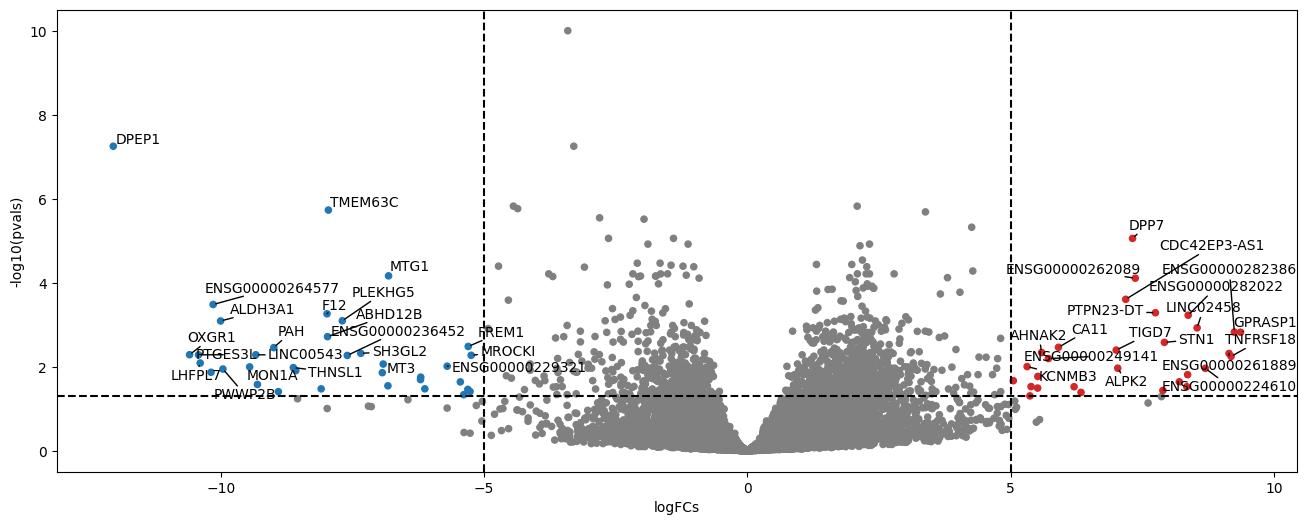

In [20]:
dc.plot_volcano_df(
    results,
    x='log2FoldChange', lFCs_thr=5,
    y='padj',
    top=40,
    figsize=(16, 6),
    #save='volcan_cancer.png'
)

In [21]:
results.to_csv(os.path.join(output_path, "de_results.csv"), index=True)

## Cancer cell

In [22]:
adata_cancer = adata[adata.obs[cell_type_key] == "Cancer cell"].copy()

In [48]:
adata_cancer.obs[patient_key].value_counts()

patient_short
P12    1810
P9     1741
P16    1559
P3     1246
P11    1065
P14    1058
P5      308
Name: count, dtype: int64

### Counts dataframe

In [23]:
adata_cancer.obs['patient_phenotype'] = (adata_cancer.obs[patient_key].astype(str) + " - " + adata_cancer.obs[phenotype_key].astype(str))
adata_cancer.obs['patient_phenotype'] = adata_cancer.obs['patient_phenotype'].astype('category')

counts_cancer = pd.DataFrame(adata_cancer.X.todense() if hasattr(adata_cancer.X, "todense") else adata_cancer.X, 
                             columns=adata_cancer.var['GeneSymbol'], 
                             index=adata_cancer.obs_names)

counts_cancer['patient_phenotype'] = adata_cancer.obs['patient_phenotype'].values
aggregated_counts = counts_cancer.groupby('patient_phenotype').sum()
aggregated_counts = aggregated_counts.astype(int)
aggregated_counts = aggregated_counts.groupby(level=0, axis=1).sum() # IMPORTANT: AGGREGATION OF DUPLICATED COLUMNS 

In [24]:
print(f"Genes: {aggregated_counts.shape[1]}")

# Filter out genes with low expression
# Keep genes with at least 10 counts in at least 3 patients
gene_keep = (aggregated_counts >= 10).sum(axis=0) >= 3
aggregated_counts = aggregated_counts.loc[:, gene_keep]

print(f"Genes left: {aggregated_counts.shape[1]}")

Genes: 28434
Genes left: 12727


### Metadata dataframe

In [25]:
adata_cancer.obs[phenotype_key] = adata_cancer.obs[phenotype_key].astype('category')

metadata_cancer = adata_cancer.obs.set_index('patient_phenotype')[[patient_key, phenotype_key]]

aggregated_metadata = metadata_cancer[~metadata_cancer.index.duplicated(keep='first')] # sure it is the one and only met
aggregated_metadata = aggregated_metadata.sort_index()

In [26]:
for col in aggregated_metadata.columns:
    aggregated_metadata[col] = aggregated_metadata[col].astype('category')

### DeSeq2

In [27]:
inference = DefaultInference(n_cpus=96)
dds = DeseqDataSet(
    counts=aggregated_counts,
    metadata=aggregated_metadata,
    design_factors=['phenotype'],
    refit_cooks=True,
    inference=inference,
)

In [28]:
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.21 seconds.

Fitting dispersion trend curve...
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 2.82 seconds.

Fitting LFCs...
... done in 1.68 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [107]:
#dds.write(os.path.join(path, 'deseq.h5ad'))

In [29]:
# default: alpha=0.05, cooks_filter=True, independent_filter=True
stat_cancer = DeseqStats(dds, contrast=["phenotype", 'inflamed', 'excluded'], inference=inference)
stat_cancer.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: phenotype inflamed vs excluded
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
GeneSymbol                                                              
A1CF         953.841706       -0.948701  0.903641 -1.049865  0.293780   
AAAS         427.696319       -0.117764  0.328757 -0.358211  0.720186   
AACS         366.750140        0.026861  0.438786  0.061216  0.951187   
AADAT        187.683959        0.738704  0.665450  1.110082  0.266964   
AAGAB        759.133732        0.319757  0.352045  0.908285  0.363728   
...                 ...             ...       ...       ...       ...   
ZXDC         629.234792        0.279189  0.350804  0.795855  0.426116   
ZYG11B       630.922731       -0.729128  0.356850 -2.043233  0.041029   
ZYX          817.125573        0.270806  0.622197  0.435242  0.663387   
ZZEF1        421.479073       -0.052653  0.738176 -0.071329  0.943136   
ZZZ3        1009.492696       -0.274311  0.235726 -1.16

... done in 0.66 seconds.



In [30]:
results_cancer = stat_cancer.results_df

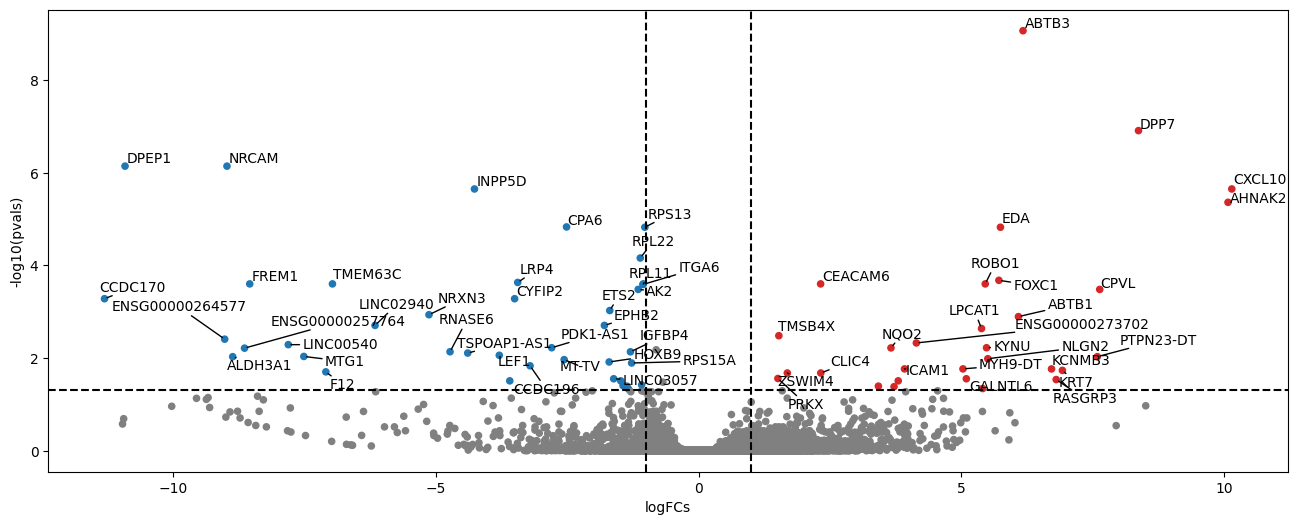

In [31]:
dc.plot_volcano_df(
    results_cancer,
    x='log2FoldChange', lFCs_thr=1,
    y='padj',
    top=60,
    figsize=(16, 6),
    save='volcan_cancer.png'
)

In [32]:
results_cancer.to_csv(os.path.join(output_path, "de_results_cancer.csv"), index=True)

In [33]:
filtered_results_cancer = results_cancer[(abs(results_cancer['log2FoldChange']) >= 1) & (results_cancer['padj'] < 0.05)]
filtered_results_cancer.to_csv(os.path.join(output_path, "filtered_de_results_cancer.csv"), index=True)

## Fibroblast

In [34]:
adata_fibroblast = adata[adata.obs[cell_type_key] == "Fibroblast"].copy()

In [47]:
adata_fibroblast.obs[patient_key].value_counts()

patient_short
P14    104
P9      79
P5      43
P12     34
P11     30
P3      19
P16     18
Name: count, dtype: int64

### Counts dataframe

In [35]:
adata_fibroblast.obs['patient_phenotype'] = (adata_fibroblast.obs[patient_key].astype(str) + " - " + adata_fibroblast.obs[phenotype_key].astype(str))
adata_fibroblast.obs['patient_phenotype'] = adata_fibroblast.obs['patient_phenotype'].astype('category')

counts_fibroblast = pd.DataFrame(adata_fibroblast.X.todense() if hasattr(adata_fibroblast.X, "todense") else adata_fibroblast.X, 
                             columns=adata_fibroblast.var['GeneSymbol'], 
                             index=adata_fibroblast.obs_names)

counts_fibroblast['patient_phenotype'] = adata_fibroblast.obs['patient_phenotype'].values
aggregated_counts = counts_fibroblast.groupby('patient_phenotype').sum()
aggregated_counts = aggregated_counts.astype(int)
aggregated_counts = aggregated_counts.groupby(level=0, axis=1).sum() # IMPORTANT: AGGREGATION OF DUPLICATED COLUMNS 

In [36]:
print(f"Genes: {aggregated_counts.shape[1]}")

# Filter out genes with low expression
# Keep genes with at least 10 counts in at least 3 patients
gene_keep = (aggregated_counts >= 10).sum(axis=0) >= 3
aggregated_counts = aggregated_counts.loc[:, gene_keep]

print(f"Genes left: {aggregated_counts.shape[1]}")

Genes: 28434
Genes left: 5701


### Metadata dataframe

In [37]:
adata_fibroblast.obs[phenotype_key] = adata_fibroblast.obs[phenotype_key].astype('category')

metadata_fibroblast = adata_fibroblast.obs.set_index('patient_phenotype')[[patient_key, 
                                                                phenotype_key]]

aggregated_metadata = metadata_fibroblast[~metadata_fibroblast.index.duplicated(keep='first')] # sure it is the one and only met
aggregated_metadata = aggregated_metadata.sort_index()
#aggregated_metadata

In [38]:
for col in aggregated_metadata.columns:
    aggregated_metadata[col] = aggregated_metadata[col].astype('category')

### DeSeq2

In [39]:
inference = DefaultInference(n_cpus=96)
dds = DeseqDataSet(
    counts=aggregated_counts,
    metadata=aggregated_metadata,
    design_factors=['phenotype'],
    refit_cooks=True,
    inference=inference,
)

In [40]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.44 seconds.

Fitting dispersion trend curve...
... done in 0.12 seconds.

Fitting MAP dispersions...
... done in 1.38 seconds.

Fitting LFCs...
... done in 0.95 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [41]:
# default: alpha=0.05, cooks_filter=True, independent_filter=True
stat_fibroblast = DeseqStats(dds, contrast=["phenotype", 'inflamed', 'excluded'], inference=inference)
stat_fibroblast.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: phenotype inflamed vs excluded
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
GeneSymbol                                                                    
A2M         252.358092        0.616943  0.731035  0.843930  0.398708  0.999361
A4GALT       14.835722       -0.720006  0.686879 -1.048229  0.294533  0.999361
AAK1         14.200977        0.087634  0.490542  0.178647  0.858215  0.999361
AAMDC        15.972784       -0.411871  0.540473 -0.762056  0.446027  0.999361
AAMP         24.766439       -0.428699  0.471081 -0.910032  0.362805  0.999361
...                ...             ...       ...       ...       ...       ...
ZSWIM6       34.300213       -0.662407  0.853068 -0.776499  0.437454  0.999361
ZSWIM8        6.946264        0.308555  0.716346  0.430735  0.666661  0.999361
ZYG11B       22.268811        0.210441  0.431471  0.487731  0.625741  0.999361
ZYX          32.401871       -0.065554  0.434007 -0.151043  0.

... done in 0.93 seconds.



In [42]:
results_fibroblast = stat_fibroblast.results_df

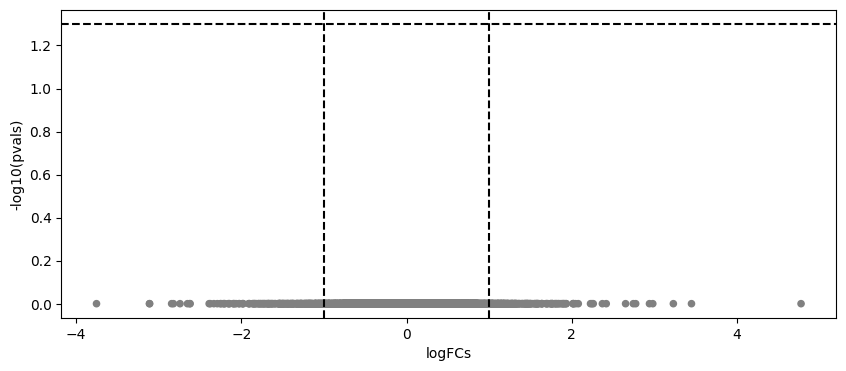

In [43]:
dc.plot_volcano_df(
    results_fibroblast,
    x='log2FoldChange', lFCs_thr=1,
    y='padj',
    top=60,
    figsize=(10, 4),
    #save=th_path
)

In [44]:
results_fibroblast.to_csv(os.path.join(output_path, "de_results_fibroblast.csv"), index=True)

## T cell

In [45]:
adata_tcell = adata[adata.obs[cell_type_key] == "T cell"].copy()

In [46]:
adata_tcell.obs[patient_key].value_counts()

patient_short
P5     2247
P14    2151
P9      898
P16     318
P11     195
P3      190
P12      64
Name: count, dtype: int64

### Counts dataframe

In [50]:
adata_tcell.obs['patient_phenotype'] = (adata_tcell.obs[patient_key].astype(str) + " - " + adata_tcell.obs[phenotype_key].astype(str))
adata_tcell.obs['patient_phenotype'] = adata_tcell.obs['patient_phenotype'].astype('category')

counts_tcell = pd.DataFrame(adata_tcell.X.todense() if hasattr(adata_tcell.X, "todense") else adata_tcell.X, 
                             columns=adata_tcell.var['GeneSymbol'], 
                             index=adata_tcell.obs_names)

counts_tcell['patient_phenotype'] = adata_tcell.obs['patient_phenotype'].values
aggregated_counts = counts_tcell.groupby('patient_phenotype').sum()
aggregated_counts = aggregated_counts.astype(int)
aggregated_counts = aggregated_counts.groupby(level=0, axis=1).sum() # IMPORTANT: AGGREGATION OF DUPLICATED COLUMNS 

In [51]:
print(f"Genes: {aggregated_counts.shape[1]}")

# Filter out genes with low expression
# Keep genes with at least 10 counts in at least 3 patients
gene_keep = (aggregated_counts >= 5).sum(axis=0) >= 2
aggregated_counts = aggregated_counts.loc[:, gene_keep]

print(f"Genes left: {aggregated_counts.shape[1]}")

Genes: 28434
Genes left: 11073


### Metadata dataframe

In [52]:
adata_tcell.obs[phenotype_key] = adata_tcell.obs[phenotype_key].astype('category')

metadata_tcell = adata_tcell.obs.set_index('patient_phenotype')[[patient_key, phenotype_key]]

aggregated_metadata = metadata_tcell[~metadata_tcell.index.duplicated(keep='first')] # sure it is the one and only met
aggregated_metadata = aggregated_metadata.sort_index()
#aggregated_metadata

In [53]:
for col in aggregated_metadata.columns:
    aggregated_metadata[col] = aggregated_metadata[col].astype('category')

### DeSeq2

In [54]:
inference = DefaultInference(n_cpus=96)
dds = DeseqDataSet(
    counts=aggregated_counts,
    metadata=aggregated_metadata,
    design_factors=['phenotype'],
    refit_cooks=True,
    inference=inference,
)

In [55]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.51 seconds.

Fitting dispersion trend curve...
... done in 0.25 seconds.

Fitting MAP dispersions...
... done in 2.63 seconds.

Fitting LFCs...
... done in 1.93 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [57]:
# default: alpha=0.05, cooks_filter=True, independent_filter=True
stat_tcell = DeseqStats(dds, contrast=["phenotype", 'inflamed', 'excluded'], inference=inference)
stat_tcell.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: phenotype inflamed vs excluded
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
GeneSymbol                                                                    
A1BG-AS1      6.101983       -2.652087  1.739681 -1.524467  0.127392  0.998549
A2M-AS1       1.846645        2.215059  2.609998  0.848682  0.396058  0.998549
AAAS         22.004219       -0.273612  0.644706 -0.424399  0.671275  0.998549
AACS         10.250313        0.153293  0.825819  0.185625  0.852739  0.998549
AAGAB        73.096438       -0.241114  0.316899 -0.760854  0.446744  0.998549
...                ...             ...       ...       ...       ...       ...
ZXDC         87.831063        0.059286  0.329428  0.179967  0.857179  0.998549
ZYG11B       58.326482        0.633887  0.492763  1.286394  0.198306  0.998549
ZYX         166.820168       -0.454163  0.237167 -1.914948  0.055499  0.998549
ZZEF1       116.262876       -0.627994  0.298072 -2.106853  0.

... done in 0.95 seconds.



In [58]:
results_tcell = stat_tcell.results_df

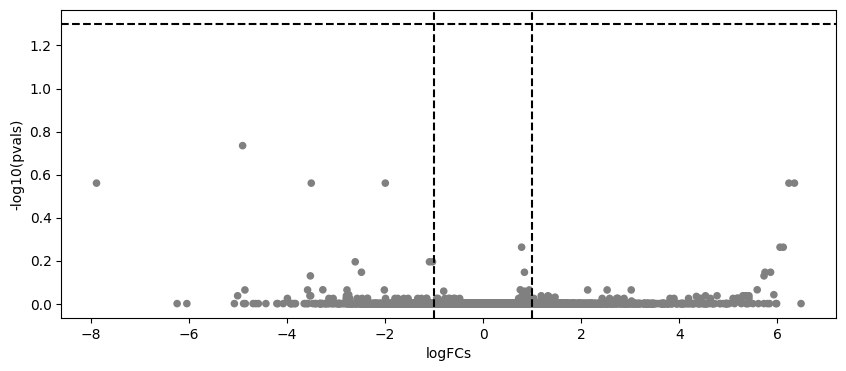

In [59]:
dc.plot_volcano_df(
    results_tcell,
    x='log2FoldChange', lFCs_thr=1,
    y='padj',
    top=60,
    figsize=(10, 4),
    #save=th_path
)

In [60]:
results_tcell.to_csv(os.path.join(output_path, "de_results_tcell.csv"), index=True)

## Neutrophil

In [61]:
adata_neutrophil = adata[adata.obs[cell_type_key] == "Neutrophil"].copy()

In [72]:
adata_neutrophil.obs[patient_key].value_counts()

patient_short
P5     4349
P9     1928
P3      960
P14     861
P16     547
P12     233
P11      35
Name: count, dtype: int64

### Counts dataframe

In [62]:
adata_neutrophil.obs['patient_phenotype'] = (adata_neutrophil.obs[patient_key].astype(str) + " - " + adata_neutrophil.obs[phenotype_key].astype(str))
adata_neutrophil.obs['patient_phenotype'] = adata_neutrophil.obs['patient_phenotype'].astype('category')

counts_neutrophil = pd.DataFrame(adata_neutrophil.X.todense() if hasattr(adata_neutrophil.X, "todense") else adata_neutrophil.X, 
                             columns=adata_neutrophil.var['GeneSymbol'], 
                             index=adata_neutrophil.obs_names)

counts_neutrophil['patient_phenotype'] = adata_neutrophil.obs['patient_phenotype'].values
aggregated_counts = counts_neutrophil.groupby('patient_phenotype').sum()
aggregated_counts = aggregated_counts.astype(int)
aggregated_counts = aggregated_counts.groupby(level=0, axis=1).sum() # IMPORTANT: AGGREGATION OF DUPLICATED COLUMNS 

In [63]:
print(f"Genes: {aggregated_counts.shape[1]}")

# Filter out genes with low expression
# Keep genes with at least 10 counts in at least 3 patients
gene_keep = (aggregated_counts >= 10).sum(axis=0) >= 3
aggregated_counts = aggregated_counts.loc[:, gene_keep]

print(f"Genes left: {aggregated_counts.shape[1]}")

Genes: 28434
Genes left: 6867


### Metadata dataframe

In [64]:
adata_neutrophil.obs[phenotype_key] = adata_neutrophil.obs[phenotype_key].astype('category')

metadata_neutrophil = adata_neutrophil.obs.set_index('patient_phenotype')[[patient_key, phenotype_key]]

aggregated_metadata = metadata_neutrophil[~metadata_neutrophil.index.duplicated(keep='first')] # sure it is the one and only met
aggregated_metadata = aggregated_metadata.sort_index()
#aggregated_metadata

In [65]:
for col in aggregated_metadata.columns:
    aggregated_metadata[col] = aggregated_metadata[col].astype('category')

### DeSeq2

In [66]:
inference = DefaultInference(n_cpus=96)
dds = DeseqDataSet(
    counts=aggregated_counts,
    metadata=aggregated_metadata,
    design_factors=['phenotype'],
    refit_cooks=True,
    inference=inference,
)

In [67]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.43 seconds.

Fitting dispersion trend curve...
... done in 0.14 seconds.

Fitting MAP dispersions...
... done in 1.52 seconds.

Fitting LFCs...
... done in 1.20 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [68]:
# default: alpha=0.05, cooks_filter=True, independent_filter=True
stat_neutrophil = DeseqStats(dds, contrast=["phenotype", 'inflamed', 'excluded'], inference=inference)
stat_neutrophil.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: phenotype inflamed vs excluded
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
GeneSymbol                                                                    
AAGAB         6.900049        0.718993  1.256438  0.572247  0.567154  0.999829
AAK1         58.187548        0.099647  0.451386  0.220757  0.825281  0.999829
AAMDC        15.608553        0.482066  1.034304  0.466078  0.641160  0.999829
AAMP         20.891293       -0.213723  0.828577 -0.257939  0.796454  0.999829
AARS1         5.079177       -0.272358  1.350687 -0.201644  0.840195  0.999829
...                ...             ...       ...       ...       ...       ...
ZXDC         52.473027        0.305304  0.579345  0.526982  0.598206  0.999829
ZYG11B       37.372827       -1.158192  0.727147 -1.592790  0.111207  0.999829
ZYX         226.050782       -0.501637  0.472021 -1.062741  0.287899  0.999829
ZZEF1        48.474718       -0.342156  0.486758 -0.702929  0.

... done in 0.82 seconds.



In [69]:
results_neutrophil = stat_neutrophil.results_df

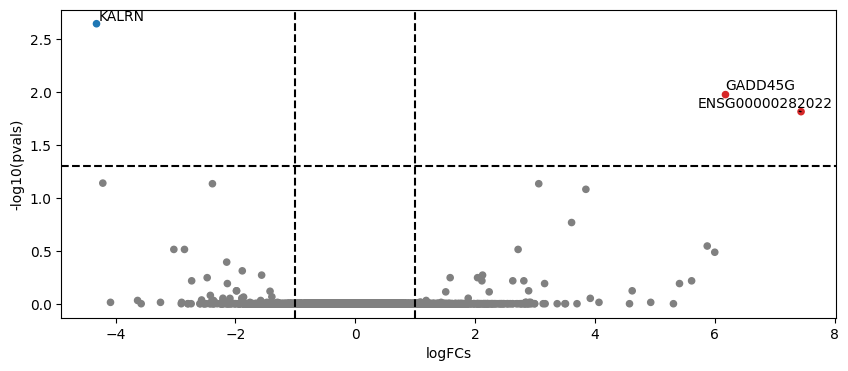

In [70]:
dc.plot_volcano_df(
    results_neutrophil,
    x='log2FoldChange', lFCs_thr=1,
    y='padj',
    top=60,
    figsize=(10, 4),
    #save=th_path
)

In [71]:
results_neutrophil.to_csv(os.path.join(output_path, "de_results_neutrophil.csv"), index=True)

## Macrophage

In [73]:
adata_macrophage = adata[adata.obs[cell_type_key] == "Macrophage"].copy()

In [74]:
adata_macrophage.obs[patient_key].value_counts()

patient_short
P3     426
P9     325
P5     309
P14    160
P16     96
P12     78
P11      5
Name: count, dtype: int64

### Counts dataframe

In [75]:
adata_macrophage.obs['patient_phenotype'] = (adata_macrophage.obs[patient_key].astype(str) + " - " + adata_macrophage.obs[phenotype_key].astype(str))
adata_macrophage.obs['patient_phenotype'] = adata_macrophage.obs['patient_phenotype'].astype('category')

counts_macrophage = pd.DataFrame(adata_macrophage.X.todense() if hasattr(adata_macrophage.X, "todense") else adata_macrophage.X, 
                             columns=adata_macrophage.var['GeneSymbol'], 
                             index=adata_macrophage.obs_names)

counts_macrophage['patient_phenotype'] = adata_macrophage.obs['patient_phenotype'].values
aggregated_counts = counts_macrophage.groupby('patient_phenotype').sum()
aggregated_counts = aggregated_counts.astype(int)
aggregated_counts = aggregated_counts.groupby(level=0, axis=1).sum() # IMPORTANT: AGGREGATION OF DUPLICATED COLUMNS 

In [76]:
print(f"Genes: {aggregated_counts.shape[1]}")

# Filter out genes with low expression
# Keep genes with at least 10 counts in at least 3 patients
gene_keep = (aggregated_counts >= 10).sum(axis=0) >= 3
aggregated_counts = aggregated_counts.loc[:, gene_keep]

print(f"Genes left: {aggregated_counts.shape[1]}")

Genes: 28434
Genes left: 8483


### Metadata dataframe

In [77]:
adata_macrophage.obs[phenotype_key] = adata_macrophage.obs[phenotype_key].astype('category')

metadata_macrophage = adata_macrophage.obs.set_index('patient_phenotype')[[patient_key, phenotype_key]]

aggregated_metadata = metadata_macrophage[~metadata_macrophage.index.duplicated(keep='first')] # sure it is the one and only met
aggregated_metadata = aggregated_metadata.sort_index()
#aggregated_metadata

In [78]:
for col in aggregated_metadata.columns:
    aggregated_metadata[col] = aggregated_metadata[col].astype('category')

### DeSeq2

In [79]:
inference = DefaultInference(n_cpus=96)
dds = DeseqDataSet(
    counts=aggregated_counts,
    metadata=aggregated_metadata,
    design_factors=['phenotype'],
    refit_cooks=True,
    inference=inference,
)

In [80]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.81 seconds.

Fitting dispersion trend curve...
... done in 0.17 seconds.

Fitting MAP dispersions...
... done in 1.64 seconds.

Fitting LFCs...
... done in 1.29 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [81]:
# default: alpha=0.05, cooks_filter=True, independent_filter=True
stat_macrophage = DeseqStats(dds, contrast=["phenotype", 'inflamed', 'excluded'], inference=inference)
stat_macrophage.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: phenotype inflamed vs excluded
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
GeneSymbol                                                                    
A2M         260.148547       -1.281537  0.440775 -2.907465  0.003644  0.963518
AAAS         13.436522        0.326764  0.837241  0.390287  0.696324  0.999827
AAGAB        23.802406       -0.161447  0.706821 -0.228413  0.819325  0.999827
AAK1         67.579763        0.436240  0.467797  0.932543  0.351056  0.999827
AAMDC        22.540846       -0.352655  0.829528 -0.425127  0.670744  0.999827
...                ...             ...       ...       ...       ...       ...
ZXDC         34.021755        0.488688  0.634534  0.770152  0.441210  0.999827
ZYG11B       40.982756        0.375918  0.527313  0.712894  0.475911  0.999827
ZYX         215.065332       -0.267245  0.371996 -0.718408  0.472506  0.999827
ZZEF1        26.233808       -1.352942  0.626853 -2.158308  0.

... done in 0.83 seconds.



In [82]:
results_macrophage = stat_macrophage.results_df

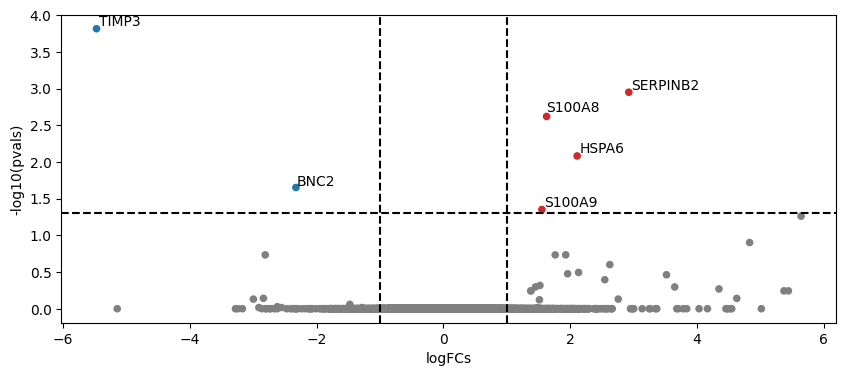

In [83]:
dc.plot_volcano_df(
    results_macrophage,
    x='log2FoldChange', lFCs_thr=1,
    y='padj',
    top=60,
    figsize=(10, 4),
    #save=th_path
)

Low expression of SerpinB2 in TAMs, often due to factors like ID1 signaling, can promote tumor immune evasion and cancer cell stemness, leading to aggravated tumor growth and metastasis.

HSPA1A can activate neutrophils.Studies using The Cancer Genome Atlas (TCGA) data have shown that HSPA2 mRNA is significantly downregulated in colon adenocarcinoma tissues compared to normal colon tissues.

Incolorectal cancer (CRC), high expression of the gene BNC2 (Basonuclin Zinc Finger Protein 2) is associated with an immunosuppressive tumor microenvironment (TME) and a poor prognosis, partly through its correlation with M2 macrophages. The resulting dense collagen matrix creates a physical barrier that protects tumor cells from immune infiltration.

S100A8, S100A9 ???
TIMP3 ???

In [84]:
results_macrophage.to_csv(os.path.join(output_path, "de_results_macrophage.csv"), index=True)